<a href="https://colab.research.google.com/github/jcauzi/jcauzi/blob/main/jcauzi/discursive%20markers%20identification/CNN_for_discursive_markers_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports des différents packages utilisés


In [ ]:
#imports 

from sys import byteorder
from array import array
from struct import pack

#import pyaudio
import wave

import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import os
import numpy as np
import random
from skimage.measure import block_reduce

#To find the duration of wave file in seconds
import wave
import contextlib

#Keras imports
from tensorflow import keras
import keras
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras.models import model_from_json

import time
import datetime

# Première ébauche de programme pour l'analyse de spectrogrammes et l'identification de marqueurs discursifs

Étapes :

1.   Extraire du corpus LOCAS une liste de fichiers .wav avec de potentiels marqueurs discurcifs (script praat) et leur classe gold. On a ainsi un corpus classifié qu'il suffit d'importer sur google colab. Un dossier par "mot candidat".
2.   Transformer chacun de ces .wav en spectrogrammes : question de la taille (durée du son), de la résolution (nb de "pixels") et du type de représentation (matrice numpy ?). 
3.   Construire et entraîner le classifieur CNN sur une partie des données : split en train / test (80% - 20%)
4.   Analyser les performances du CNN sur les données de test. 






# 1 : transformation .wav -> numpy spectrogram

In [ ]:
def findDuration(fname):
    with contextlib.closing(wave.open(fname,'r')) as f:
        frames = f.getnframes()
        rate = f.getframerate()
        sw   = f.getsampwidth()
        chan = f.getnchannels()
        duration = frames / float(rate)
        #print("File:", fname, "--->",frames, rate, sw, chan)
        return duration

#Plot Spectrogram
def graph_spectrogram(wav_file, nfft=512, noverlap=511):
    findDuration(wav_file)
    rate, data = wavfile.read(wav_file)
    #print("")
    fig,ax = plt.subplots(1)
    fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
    ax.axis('off')
    #pour régler le problème des fichiers stéréo : on ne séléction que la première piste
    if len(data.shape)>1 :
      data = data[:,0]
    pxx, freqs, bins, im = ax.specgram(x=data, Fs=rate, noverlap=noverlap, NFFT=nfft)
    ax.axis('off')
    plt.rcParams['figure.figsize'] = [0.75,0.5]
    #décommenter la ligne suivante pour exporter le spectrogramme en image png
    #fig.savefig((wav_file + ".png"), dpi=300, frameon='false')
    fig.canvas.draw()
    size_inches  = fig.get_size_inches()
    dpi          = fig.get_dpi()
    width, height = fig.get_size_inches() * fig.get_dpi()

    #print(size_inches, dpi, width, height)
    mplimage = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    #print("MPLImage Shape: ", np.shape(mplimage))
    imarray = np.reshape(mplimage, (int(height), int(width), 3))
    plt.close(fig)
    return imarray

#Convert color image to grayscale and normalize it
def rgb2normalized_gray(rgb):
    array = np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
    return (array - array.min())/(array.max() - array.min())


################################################################################

#Quelques print pour tester les fonctions :

#print(rgb2normalized_gray(graph_spectrogram("md10.wav")))
#print(rgb2normalized_gray(graph_spectrogram("SV18.wav")))
#print(rgb2normalized_gray(graph_spectrogram("test3.wav")).shape)


# for filename in os.listdir("tests") :
#   graph_spectrogram("tests/" + filename)

# 2 : Création du corpus et split train / test :

In [ ]:
imwidth                             = 18
imheight                            = 12



def create_train_test(audio_dir):
    file_names = [f for f in os.listdir(audio_dir) if '.wav' in f]
    file_names.sort()
    test_list = []
    train_list = []
    
    
    #takes approximately 20% of the list of examples randomly
    test_list.extend(random.sample(file_names, len(file_names)//5))
    #print(len(file_names)//5)
    #print(test_list)

    train_list = [x for x in file_names if x not in test_list]

    y_test = np.zeros(len(test_list))
    y_train = np.zeros(len(train_list))
    x_train = np.zeros((len(train_list), imheight, imwidth))
    x_test = np.zeros((len(test_list), imheight, imwidth))

    tuni1   = np.zeros(len(test_list))
    tuni2   = np.zeros(len(test_list))

    for i, f in enumerate(test_list):
        if f[0:2] == "md" :
          y_test[i]   = 1
        else :
          y_test[i]   = 0
        spectrogram   = graph_spectrogram( audio_dir + '/' + f )
        normgraygram  = rgb2normalized_gray(spectrogram)
        norm_shape    = normgraygram.shape
        if(norm_shape[0]>150):
            continue
        redgram       = block_reduce(normgraygram, block_size = (3,3), func = np.mean)
        x_test[i,:,:] = redgram
        print("Progress Test Data: {:2.1%}".format(float(i) / len(test_list)), end="\r")

    for i, f in enumerate(train_list):
        if f[0:2] == "md" :
          y_train[i]   = 1
        else :
          y_train[i]   = 0
        spectrogram   = graph_spectrogram( audio_dir + '/' + f )
        normgraygram  = rgb2normalized_gray(spectrogram)
        norm_shape    = normgraygram.shape
        if(norm_shape[0]>150):
            continue
        redgram       = block_reduce(normgraygram, block_size = (3,3), func = np.mean)
        x_train[i,:,:] = redgram
        print("Progress Training Data: {:2.1%}".format(float(i) / len(train_list)), end="\r")
        
    return x_train, y_train, x_test, y_test

#x_train, y_train, x_test, y_test = create_train_test("enfin/")
#print(x_test[0])
#print(y_test)


# 3. Implémentation du CNN
Il suffit de changer le nom du dossier contenant les occurences d'un mot donné dans la dernière ligne du code : 
create_model("mot/")

Size of Training Data: (38, 12, 18)
Size of Training Labels: (38,)
Size of Test Data: (9, 12, 18)
Size of Test Labels: (9,)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 10, 16, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 14, 64)         18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 7, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 4, 7, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1792)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               229504 

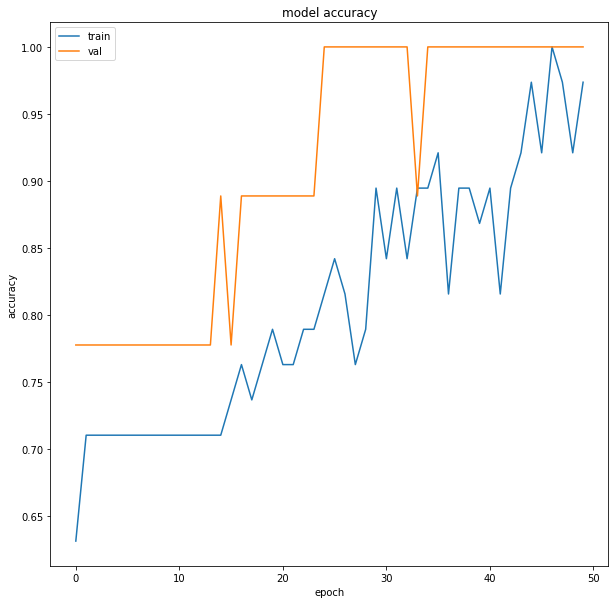

In [ ]:
imwidth                             = 18
imheight                            = 12
num_classes                         = 2

#Create Keras Model
def create_model(path) : #x_train, y_train, x_test, y_test):
    x_train, y_train, x_test, y_test = create_train_test(path)

    print("Size of Training Data:", np.shape(x_train))
    print("Size of Training Labels:", np.shape(y_train))
    print("Size of Test Data:", np.shape(x_test))
    print("Size of Test Labels:", np.shape(y_test))

    y_train = np_utils.to_categorical(y_train, num_classes)
    y_test = np_utils.to_categorical(y_test, num_classes)

    x_train = x_train.reshape(x_train.shape[0], imheight, imwidth, 1)
    x_test = x_test.reshape(x_test.shape[0], imheight, imwidth, 1)
    input_shape = (imheight, imwidth, 1)
    batch_size = 4
    epochs = 1

    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    #es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=50)

    model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
    print(model.summary())

    history = model.fit(x_train, y_train, batch_size=4, epochs=50, verbose=1, validation_data=(x_test, y_test))#, callbacks=[es])

    from matplotlib import pyplot as plt
    plt.figure(figsize=(10,10))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


    return model
  
################################################################################

#mettre le mot correspondant au nom du dossier qui contient les occurences
create_model("enfin/")
